In [2]:
# select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
#imports 
import numpy as np
import h5py
import scipy.io
from sklearn.metrics import confusion_matrix
import pandas as pd
from DCASE_plots import plot_confusion_matrix

import librosa
import soundfile as sound
import keras
import tensorflow
print("Librosa version = ",librosa.__version__)
print("Pysoundfile version = ",sound.__version__)
print("keras version = ",keras.__version__)
print("tensorflow version = ",tensorflow.__version__)

2024-07-23 16:43:09.746402: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 16:43:11.710191: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Librosa version =  0.10.1
Pysoundfile version =  0.12.1
keras version =  3.3.3
tensorflow version =  2.16.1


In [4]:
#Task 1a dev validation set
ThisPath = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/'
File = ThisPath + 'evaluation_setup/fold1_evaluate.csv'
sr = 48000
SampleDuration = 10
NumFreqBins = 128
NumFFTPoints = 2048
HopLength = int(NumFFTPoints/2)
NumTimeBins = int(np.ceil(SampleDuration*sr/HopLength))

In [5]:
File

'/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/evaluation_setup/fold1_evaluate.csv'

In [6]:
#load filenames and labels
dev_test_df = pd.read_csv(File,sep='\t', encoding='ASCII')
wavpaths = dev_test_df['filename'].tolist()
ClassNames = np.unique(dev_test_df['scene_label'])
y_val_labels =  dev_test_df['scene_label'].astype('category').cat.codes.values

In [7]:
ClassNames

array(['airport', 'bus', 'metro', 'metro_station', 'park',
       'public_square', 'shopping_mall', 'street_pedestrian',
       'street_traffic', 'tram'], dtype=object)

In [8]:
## load wav files and get log-mel spectrograms, deltas, and delta-deltas
# def deltas(X_in):
#     X_out = (X_in[:,:,2:,:]-X_in[:,:,:-2,:])/10.0
#     X_out = X_out[:,:,1:-1,:]+(X_in[:,:,4:,:]-X_in[:,:,:-4,:])/5.0
#     return X_out

LM_val = np.zeros((len(wavpaths),NumFreqBins,NumTimeBins,2),'float32')
for i in range(len(wavpaths)):
    stereo,fs = sound.read(ThisPath + wavpaths[i],stop=SampleDuration*sr)
    for channel in range(2):
        LM_val[i,:,:,channel]= librosa.feature.melspectrogram(y = stereo[:,channel], 
                                       sr=sr,
                                       n_fft=NumFFTPoints,
                                       hop_length=HopLength,
                                       n_mels=NumFreqBins,
                                       fmin=0.0,
                                       fmax=sr/2,
                                       htk=True,
                                       norm=None)

LM_val=np.log(LM_val)
# LM_deltas_val = deltas(LM_val)
# LM_deltas_deltas_val = deltas(LM_deltas_val)
# LM_val = np.concatenate((LM_val[:,:,4:-4,:],LM_deltas_val[:,:,2:-2,:],LM_deltas_deltas_val),axis=-1)


In [9]:
print(LM_val.shape)

(4185, 128, 469, 2)


In [10]:
from DCASE2019_improvised_network import PadChannels
from DCASE2019_improvised_network import SliceLayer

custom_objects = {
    'PadChannels': PadChannels,
    'SliceLayer': SliceLayer
}


#load and run the model
# best_model = keras.saving.load_model("/work/aistwal/backup/MMDS_MasterThesis/models/asc/largemodel_checkpoint/model_62-1.14.keras")
# best_model = keras.saving.load_model("/work/aistwal/DCASE2019-Task1/asc_checkpoints/model_62-1.13.keras")
best_model = keras.saving.load_model("/work/aistwal/DCASE2019-Task1/asc_checkpoints/model_126-1.13.keras")
# best_model = keras.models.load_model("/work/aistwal/backup/MMDS_MasterThesis/models/asc/largemodel_checkpoint/DCASE_1a_Task_development_1.h5", custom_objects=custom_objects)
best_model.summary()

2024-07-23 16:53:42.236920: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45914 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:61:00.0, compute capability: 8.6


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, None, │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer         │ (None, 64, None,  │          0 │ input_layer[0][0] │
│ (SliceLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer_1       │ (None, 64, None,  │          0 │ input_layer[0][0] │
│ (SliceLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, None,  │          8 │ slice_layer[0][0] │
│ (BatchNormalizatio… │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, None,  │          8 │ slice_layer_1[0]… │
│ (BatchNormalizatio… │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, None,  │        432 │ batch_normalizat… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, None,  │      6,912 │ batch_normalizat… │
│                     │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, None,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, None,  │      1,536 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, None,  │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 64, None,  │          0 │ batch_normalizat… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, None,  │      5,184 │ activation[0][0]  │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, None,  │  1,327,104 │ activation_16[0]… │
│                     │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, None,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, None,  │      1,536 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, None,  │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 64, None,  │          0 │ batch_normalizat

 Total params: 874,743,262 (3.26 GB)

 Trainable params: 437,334,440 (1.63 GB)

 Non-trainable params: 74,380 (290.55 KB)

 Optimizer params: 437,334,442 (1.63 GB)

In [11]:
y_pred_val = np.argmax(best_model.predict(LM_val),axis=1)
y_pred_val

2024-07-23 16:54:49.221648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2009871360 exceeds 10% of free system memory.
2024-07-23 16:54:52.359062: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2009871360 exceeds 10% of free system memory.
I0000 00:00:1721746494.543381 3228098 service.cc:145] XLA service 0x7f98580a95e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721746494.543447 3228098 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-07-23 16:54:54.613021: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-23 16:54:54.964309: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-07-23 16:55:48.091324: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm e

  1/131 ━━━━━━━━━━━━━━━━━━━━ 6:55:17 192s/step

I0000 00:00:1721746685.378246 3228098 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/131 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

2024-07-23 17:03:16.149964: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[25,1536,64,59]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,1536,64,59]{3,2,1,0}, f32[1536,1536,3,3]{3,2,1,0}, f32[1536]{0}, f32[25,1536,64,59]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":1,"leakyrelu_alpha":0}} is taking a while...
2024-07-23 17:03:17.462165: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.312331033s
Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[25,1536,64,59]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,1536,64,59]{3,2,1,0}, f32[1536,1536,3,3]{3,2,1,0}, f32[1536]{0}, f32[25,1536,64,59]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01

131/131 ━━━━━━━━━━━━━━━━━━━━ 620s 3s/step


array([7, 2, 4, ..., 9, 9, 9])

In [12]:
# # Swap codes for predicted labels to match the DCASE ordering of classes
# a1_pred = np.where(y_pred_val == 2)
# a2_pred = np.where(y_pred_val == 3)
# y_pred_val.setflags(write=1)
# y_pred_val[a1_pred] = 3
# y_pred_val[a2_pred] = 2

overall accuracy:  0.7794504181600955
Normalized confusion matrix
per-class accuracy (recall):  [0.73871734 0.88433735 0.72979215 0.76781609 0.91709845 0.67183463
 0.71201814 0.70629371 0.90049751 0.78211009]
per-class precision:  [0.72494172 0.87799043 0.75598086 0.78959811 0.88279302 0.69892473
 0.75845411 0.74814815 0.80088496 0.75275938]
mean per-class recall:  0.7810515450808134
mean per-class precision:  0.7790475466272963


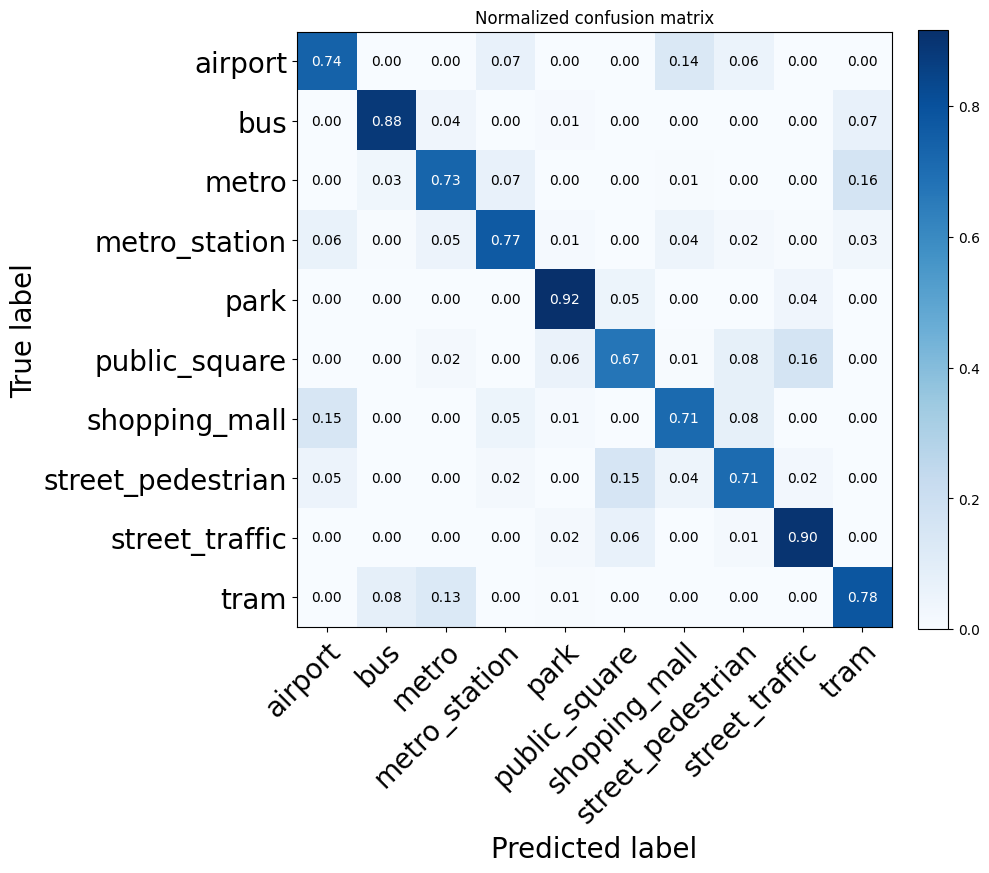

In [13]:
#get metrics
Overall_accuracy = np.sum(y_pred_val==y_val_labels)/LM_val.shape[0]
print("overall accuracy: ", Overall_accuracy)

plot_confusion_matrix(y_val_labels, y_pred_val, ClassNames,normalize=True,title=None)


conf_matrix = confusion_matrix(y_val_labels,y_pred_val)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
conf_mat_norm_precision = conf_matrix.astype('float32')/conf_matrix.sum(axis=0)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
precision_by_class = np.diagonal(conf_mat_norm_precision)
mean_recall = np.mean(recall_by_class)
mean_precision = np.mean(precision_by_class)

print("per-class accuracy (recall): ",recall_by_class)
print("per-class precision: ",precision_by_class)
print("mean per-class recall: ",mean_recall)
print("mean per-class precision: ",mean_precision)

Create dataframe

In [14]:
dev_test_df.head()

,filename,scene_label
0,audio/street_pedestrian-lyon-1162-44093-a.wav,street_pedestrian
1,audio/metro-prague-1163-44094-a.wav,metro
2,audio/park-milan-1164-44095-a.wav,park
3,audio/street_pedestrian-milan-1165-44096-a.wav,street_pedestrian
4,audio/street_traffic-milan-1166-44097-a.wav,street_traffic


In [15]:
y_pred_val_new = y_pred_val

In [16]:
dev_test_df['predicted_scene_label'] = y_pred_val_new

In [17]:
# Create a mapping from the integral codes back to the class names
code_to_class = dict(enumerate(dev_test_df['scene_label'].astype('category').cat.categories))

# Map the predicted codes to class names
dev_test_df['predicted_scene_label'] = dev_test_df['predicted_scene_label'].map(code_to_class)

In [18]:
dev_test_df['class_from_filename'] = dev_test_df['filename'].map(lambda x : x.split("/")[-1].split('-')[0])

In [19]:
# Checking whether all the class names mentioned in filenames are exactly the same as scene_labels to maintain consistency with labelling
dev_test_df[dev_test_df['class_from_filename']==dev_test_df['scene_label']].shape[0]

4185

In [20]:
correct = dev_test_df[dev_test_df['scene_label'] == dev_test_df['predicted_scene_label']]
correct.shape

(3262, 4)

In [21]:
Overall_accuracy = correct.shape[0]/LM_val.shape[0]
Overall_accuracy

0.7794504181600955

In [22]:
dev_test_df.drop(['class_from_filename'], axis = 1, inplace = True)

In [23]:
dev_test_df.columns

Index(['filename', 'scene_label', 'predicted_scene_label'], dtype='object')

In [24]:
dev_test_df.to_csv('126epoch_largemodel_predictions.csv')
# dev_test_df.to_csv('62epoch_largemodel_predictions.csv')
# dev_test_df.to_csv('120epoch_largemodel_predictions.csv')